In [1]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

from multiprocessing import Pool
from functools import partial

In [2]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Jointcal"
directory = DATADIR+"/jointcal_testSN_2/"
butler = dafPersist.Butler(directory) 
filter = 'r'


In [3]:
stack_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}
snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}

In [4]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

dates = []
days_file=open(DATADIR+"/days_06.txt", "rb")

for day in days_file:
    day = day.replace('\n','')
    dates.append(day)

days_file.close()

In [5]:

def get_light_curves_per_patch(butler, filter, dates, patch):

    multi_matches = None
    results = []
    stack_lcs = []
    for date in dates:
        t = Time(date)
        date_catalog = None
        #print date
        if butler.datasetExists("dayDiff_class_diaSrc", dataId={"filter":filter,"tract":0, "patch":patch, 'date':date}):
            date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":filter,"tract":0, "patch":patch, 'date':date})
            if multi_matches is None:
                multi_matches= afwTable.MultiMatch(date_catalog.schema, {'mjd':'D'}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
            multi_matches.add(date_catalog, {'mjd':int(t.mjd)})


    if multi_matches is not None:
        results = multi_matches.finish(removeAmbiguous=False)
        lcs = DSTools.get_light_curves_from_multimatch_results2(results)
        t_lcs = DSTools.threshold_light_curves(lcs, 3)
        for t_lc in t_lcs:
            stack_lcs.append(DSTools.build_lightcurve5(t_lc, "base_CircularApertureFlux_4_5_flux", filter))
            
    return patch, stack_lcs

def function(args):
    return get_light_curves_per_patch(*args)

In [6]:
p = Pool(200)



params = [(butler, 'r', dates, patch) for patch in patches]
#params2 = [(butler, 'g', dates, patch) for patch in patches]
#params3 = [(butler, 'i', dates, patch) for patch in patches]


#params.extend(params2)
#params.extend(params3)


#butler_z = dafPersist.Butler("/datadec/cppm/jpreyes/CFHT_filter_z/detect_testSN_6") 
#params4 = [(butler, 'z', dates, patch) for patch in patches]

#params.extend(params4)
#print params
res = p.map(function, params)
#f = Pool(25).map(get_light_curves_per_patch, ([butler], ['g'], ['0,20'], [dates]))

In [7]:
from astropy.table import Table, vstack
lcs = {}
for r in res:
    if len(r[1])>0:
        if lcs.has_key(r[0]):
            lcs[r[0]].extend(r[1])
        else:
            lcs[r[0]] = r[1]

lcs2 = lcs
lcs = lcs.values()
print len(lcs)

356


In [8]:
lcs2.keys()

['22,16',
 '22,17',
 '22,14',
 '22,15',
 '22,12',
 '22,13',
 '22,10',
 '22,11',
 '22,18',
 '22,19',
 '15,14',
 '15,15',
 '15,16',
 '15,17',
 '15,10',
 '15,11',
 '15,12',
 '15,13',
 '15,18',
 '15,19',
 '23,19',
 '23,18',
 '23,15',
 '23,14',
 '23,17',
 '23,16',
 '21,22',
 '23,10',
 '23,13',
 '21,21',
 '24,13',
 '11,18',
 '11,19',
 '11,10',
 '11,11',
 '11,12',
 '11,13',
 '11,14',
 '11,15',
 '11,16',
 '11,17',
 '6,15',
 '6,14',
 '6,17',
 '6,16',
 '6,11',
 '6,10',
 '6,13',
 '6,12',
 '6,18',
 '8,9',
 '8,8',
 '8,7',
 '8,6',
 '8,5',
 '16,20',
 '16,21',
 '16,22',
 '16,23',
 '15,21',
 '15,20',
 '15,23',
 '15,22',
 '13,5',
 '13,6',
 '13,7',
 '13,8',
 '13,9',
 '17,5',
 '17,6',
 '17,7',
 '17,8',
 '17,9',
 '12,20',
 '12,21',
 '12,22',
 '12,23',
 '11,21',
 '11,20',
 '11,23',
 '11,22',
 '17,16',
 '17,17',
 '17,14',
 '17,15',
 '17,12',
 '17,13',
 '17,10',
 '17,11',
 '17,18',
 '17,19',
 '19,6',
 '19,7',
 '19,5',
 '19,8',
 '19,9',
 '16,19',
 '16,18',
 '16,15',
 '16,14',
 '16,17',
 '16,16',
 '14,22',
 '14

In [ ]:


def build_multi_filter_lc(lcs):
    final_lc = []
 
    for lc in lcs:
        added = False
        
        for i, f_lc in enumerate(final_lc):
            s1 = {'ra':np.mean(lc["ra"]), 'dec':np.mean(lc["dec"])}
            s2 = {'ra':np.mean(f_lc["ra"]), 'dec':np.mean(f_lc["dec"])}
      
            if DSTools.source_distance(s1,s2)<1:             
                added = True
                final_lc[i] = vstack([lc, f_lc])
                  #print final_lc[i]
        if added == False:
                  final_lc.append(lc)
                  
    return final_lc
        

In [ ]:
p = Pool(100)
mf_lcs = p.map(build_multi_filter_lc, lcs)

In [ ]:
tot_lcs = []
for p_lc in mf_lcs:
    tot_lcs.extend(p_lc)

In [13]:
len(tot_lcs)

164147

In [14]:
def show_multi_filter_light_curve(t, colors, n_factor = None):

    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    #print indices

    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()

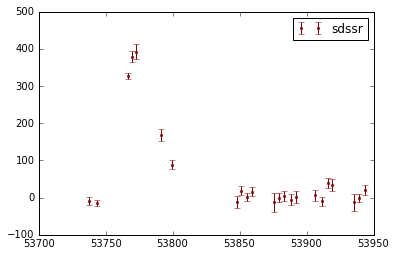

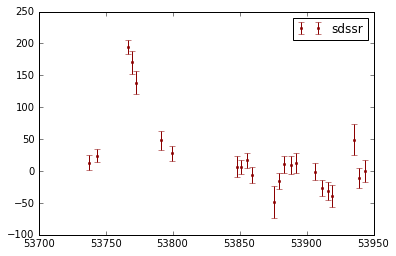

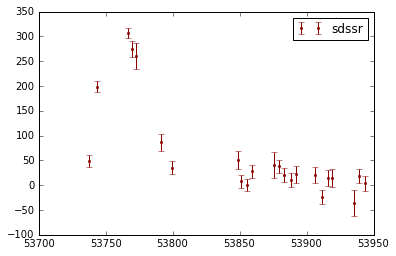

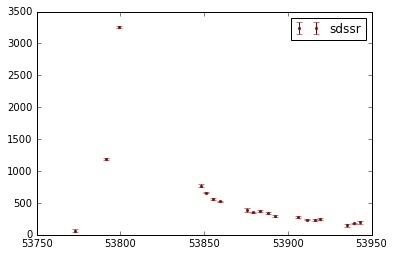

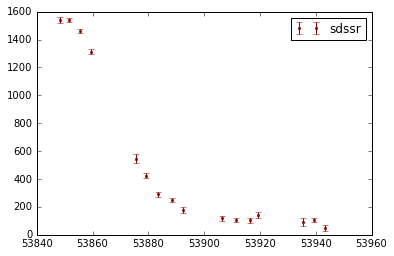

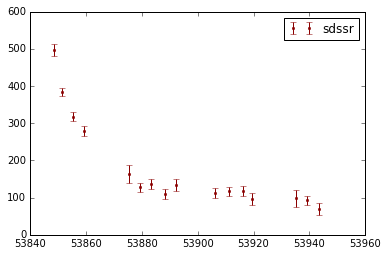

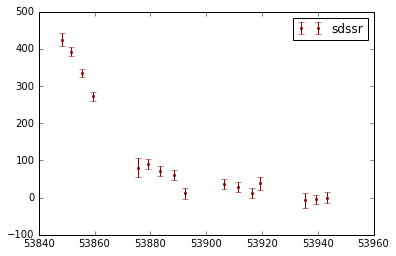

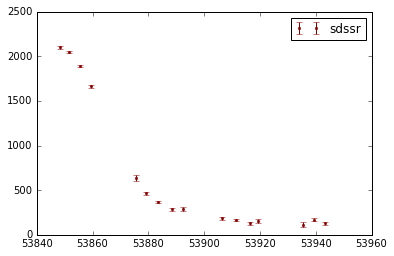

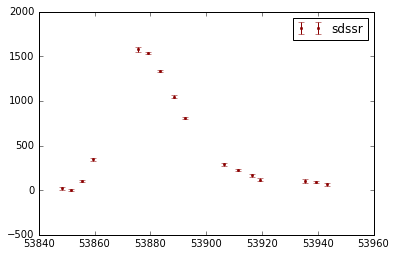

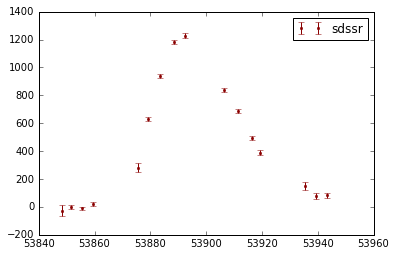

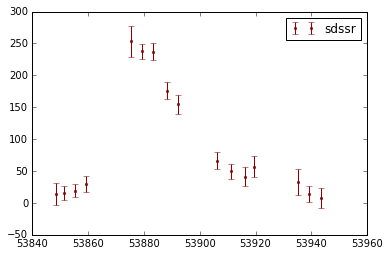

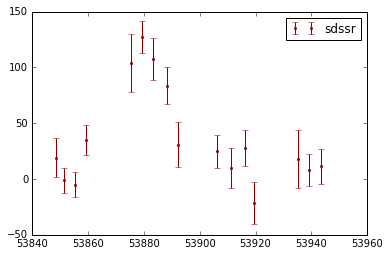

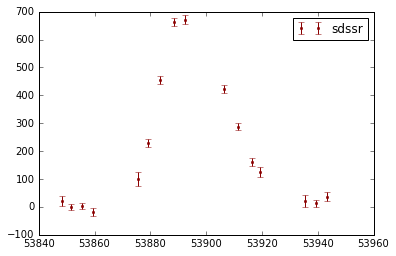

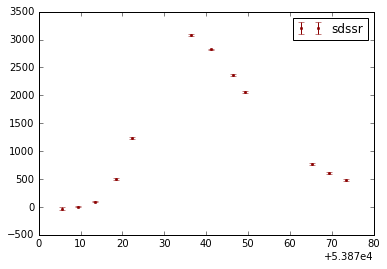

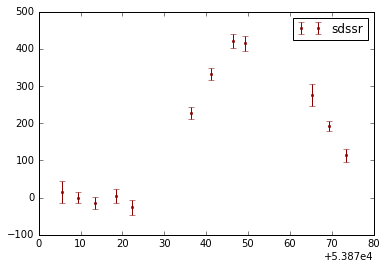

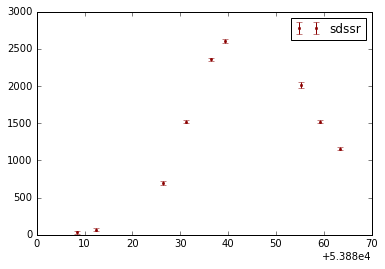

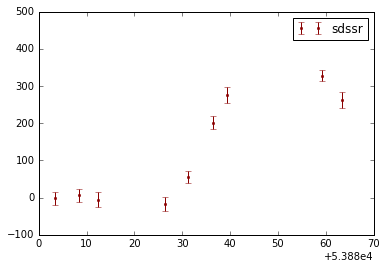

In [15]:
%matplotlib inline
import re
import astropy.coordinates as coord
import astropy.units as u


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|(r)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = DSTools.build_light_curve_from_snls_file(m, c)
    
    #print m
    #print sn[0], c.ra.deg, c.dec.deg
    
    #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    show_multi_filter_light_curve(snls_lc, snls_colors)
    plt.show()
    snls_array.append(snls_lc)
    

In [16]:
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc,slc))


    print len(matches)
    return matches

In [17]:
stats = []
for lc in tot_lcs:
    t_by_filter = lc.group_by("bandpass")
    indices = t_by_filter.groups.indices
    stats.append(len(indices)-1)
    

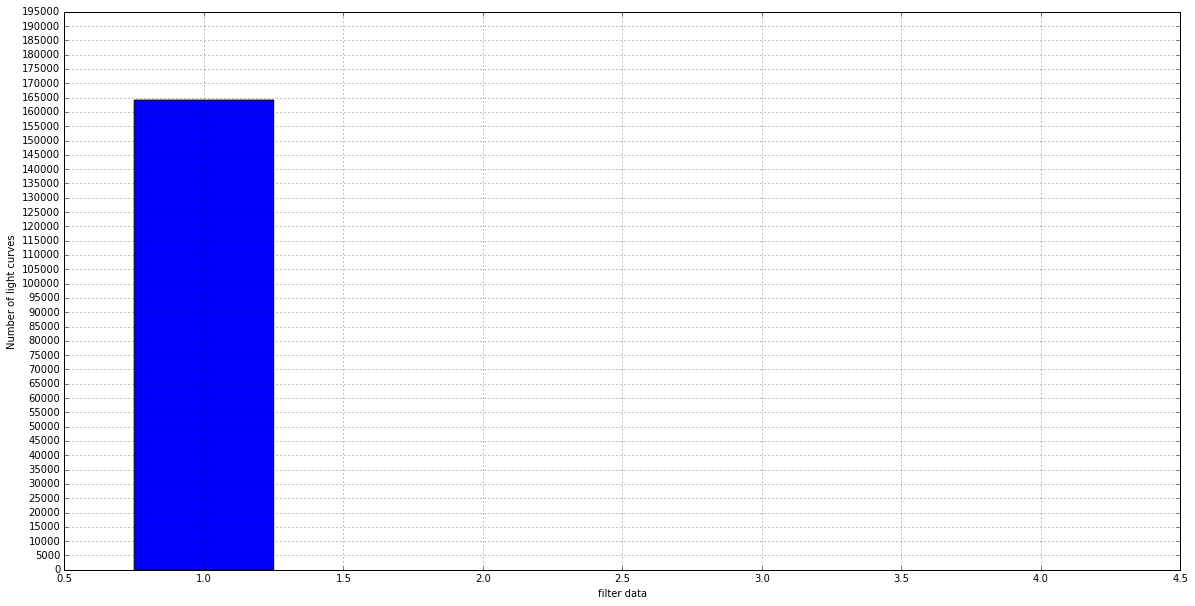

In [18]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.hist(stats, bins=range(1,6,1), align='left', rwidth=0.5)
plt.ylabel("Number of light curves")
plt.xlabel("filter data")
plt.yticks(np.arange(0,200000,5000))
plt.grid(True)
plt.show()

In [19]:
matches_45= match_with_lc(snls_array, tot_lcs)

8234
143597
1731
65231
142781
152785
44742
45675
135590
114062
72532
32863
64238
13


In [20]:
len(snls_array)

17

In [25]:
def normalize_light_curve(lc1, lc2, filter):
   
    l1 = lc1[lc1['bandpass']==filter]
    l2 = lc2[lc2['bandpass']==filter]
    norm = []
    for row1 in l1:
        for row2 in l2:
            if int(row1["mjd"]) == int(row2["mjd"]):
                norm.append(row1["flux"]/row2["flux"])
                
    c_array = sigmaclip(norm, low=1.5, high=1.5)
    return c_array.clipped.mean()

In [26]:
from scipy.stats import sigmaclip

214.291914039 53.0247931329
{'sdssi': nan, 'sdssr': 24.125960028552733, 'sdssz': nan, 'sdssg': nan}


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-

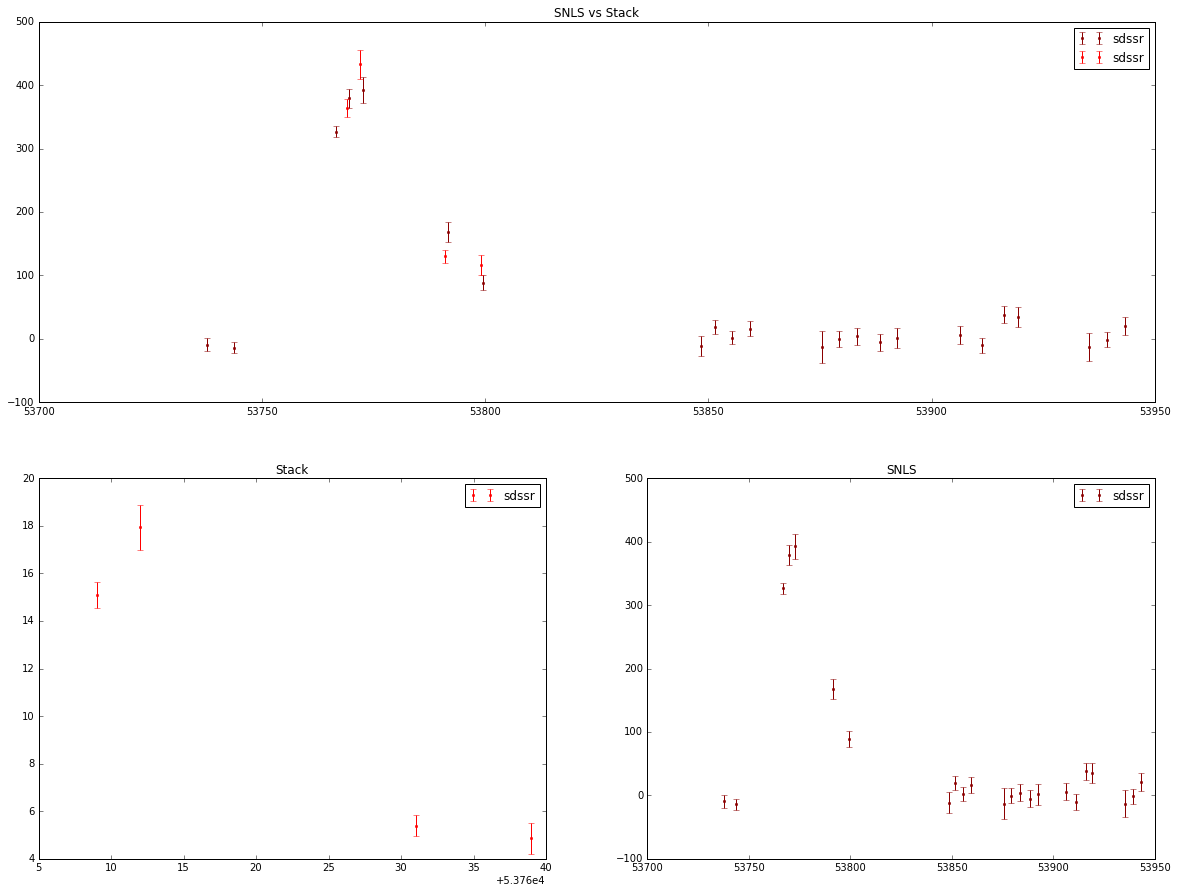

214.381703468 52.9124275511
{'sdssi': nan, 'sdssr': 26.260696779368132, 'sdssz': nan, 'sdssg': nan}


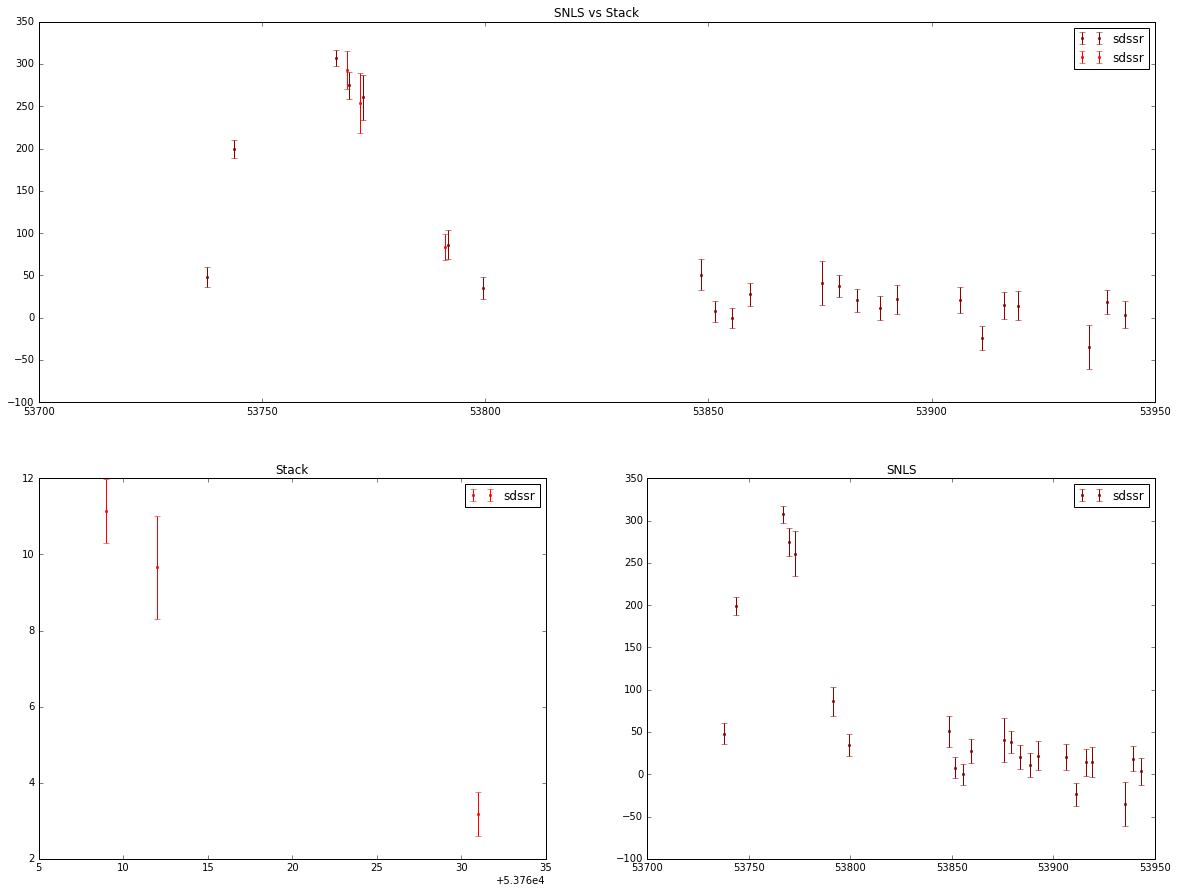

214.857571098 52.6410360727
{'sdssi': nan, 'sdssr': 21.79220479247191, 'sdssz': nan, 'sdssg': nan}


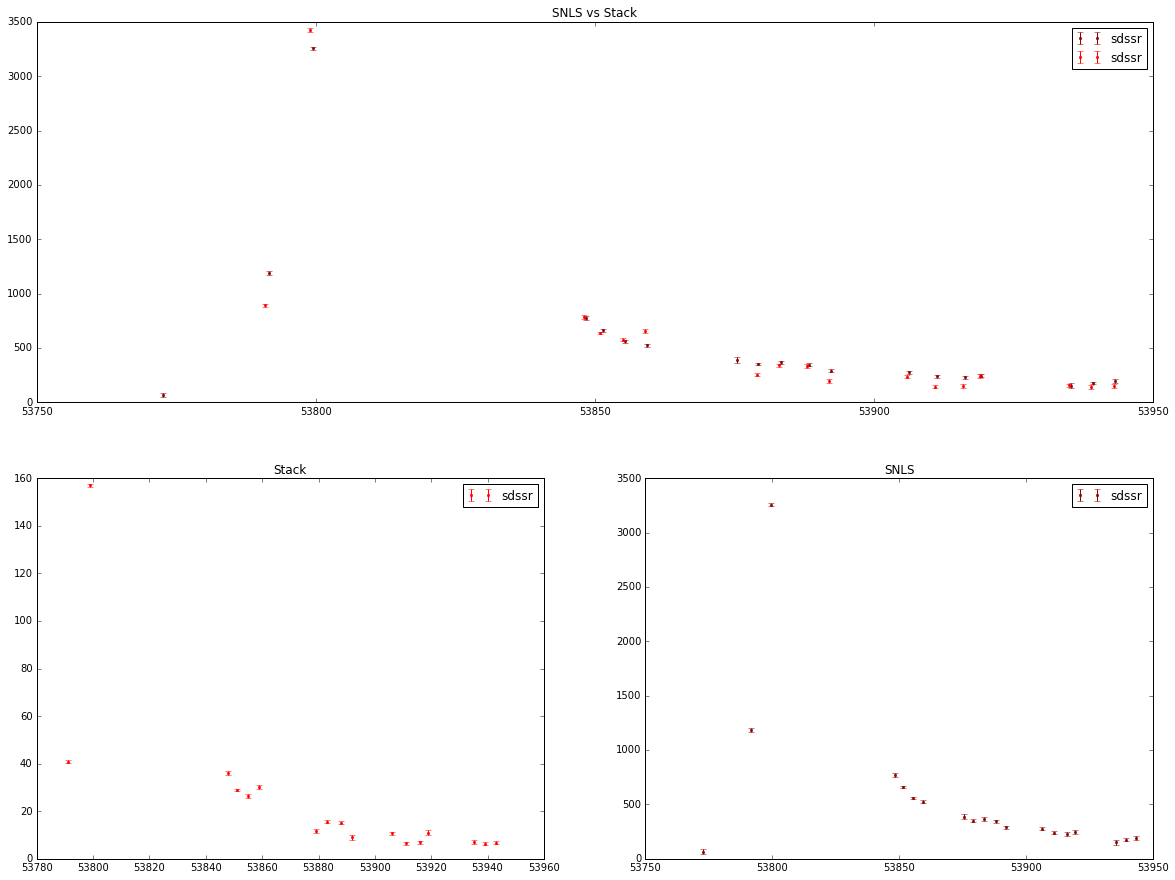

214.857581648 52.6409027672
{'sdssi': nan, 'sdssr': 25.864286180245866, 'sdssz': nan, 'sdssg': nan}


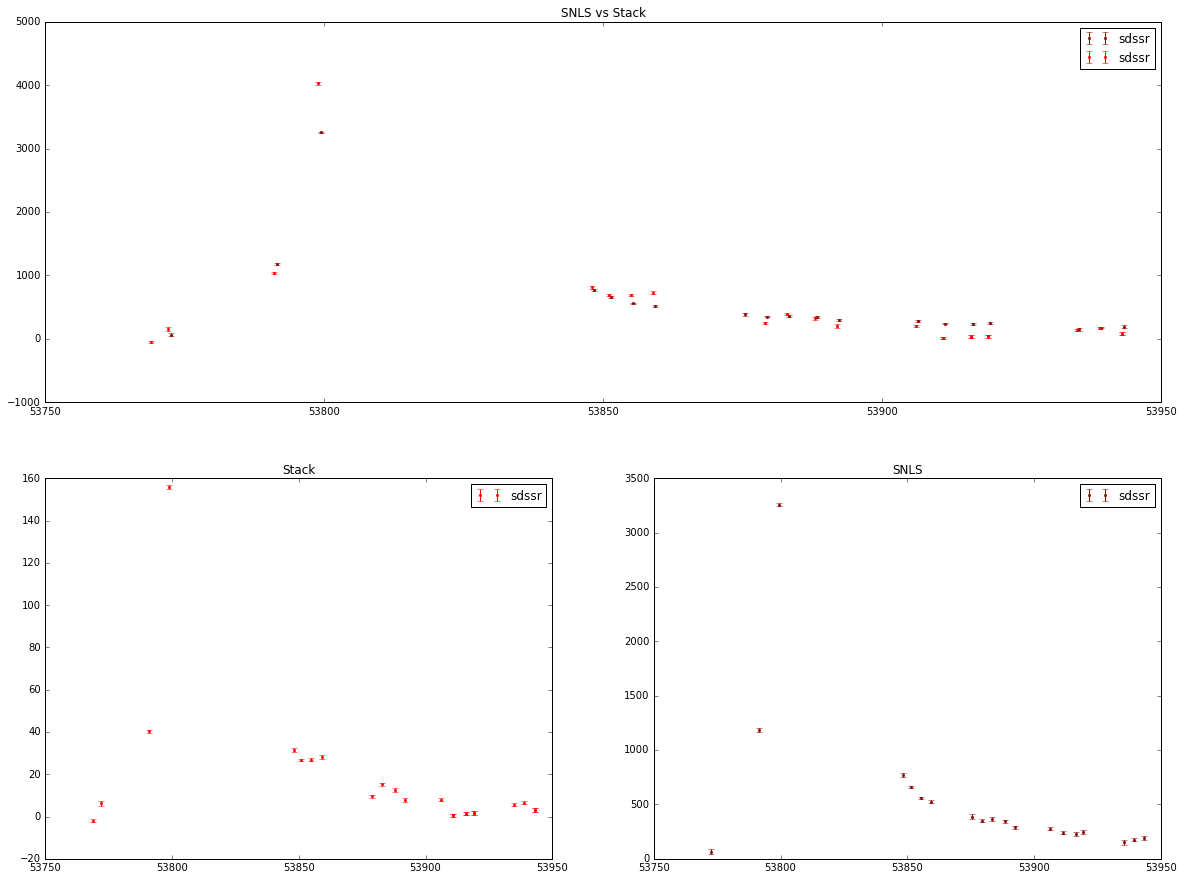

214.857593531 52.6409852077
{'sdssi': nan, 'sdssr': 22.133991392344317, 'sdssz': nan, 'sdssg': nan}


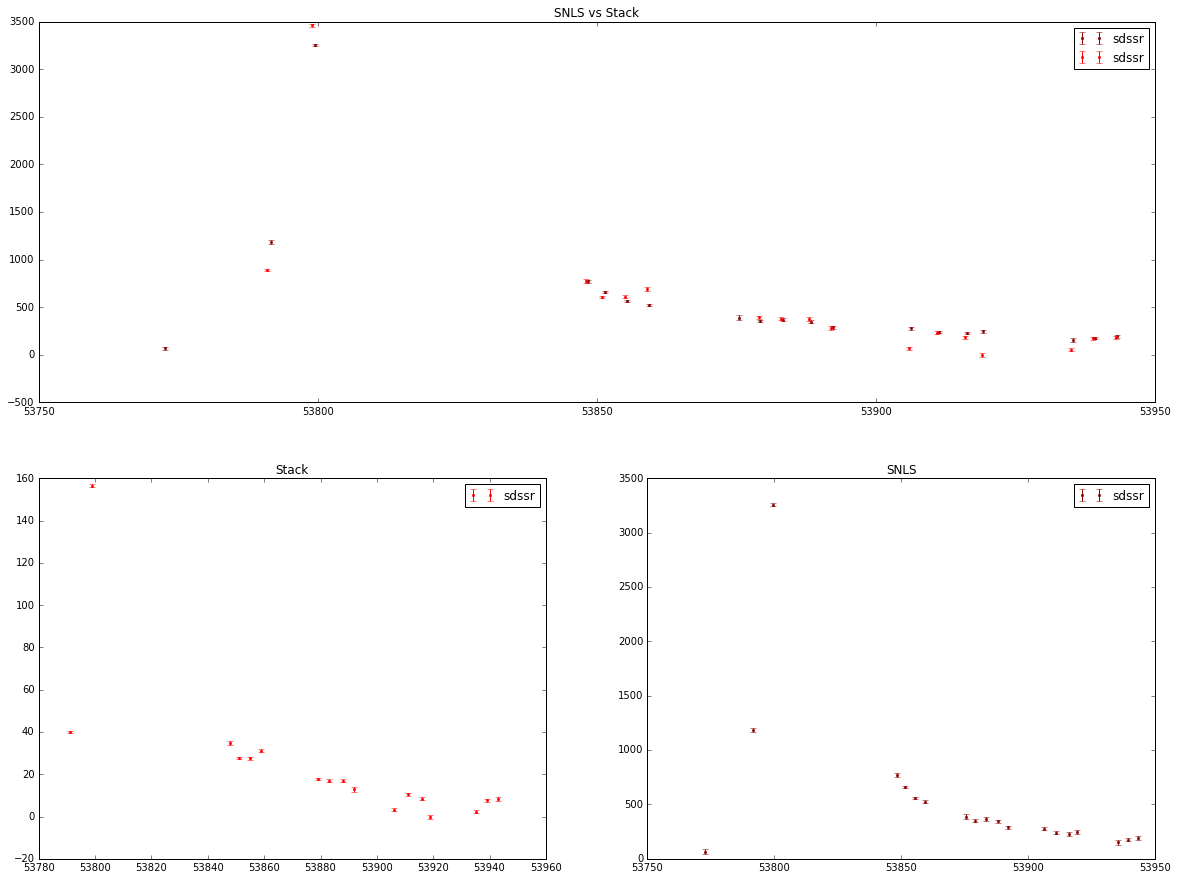

214.857576033 52.6410454276
{'sdssi': nan, 'sdssr': 23.592519437998178, 'sdssz': nan, 'sdssg': nan}


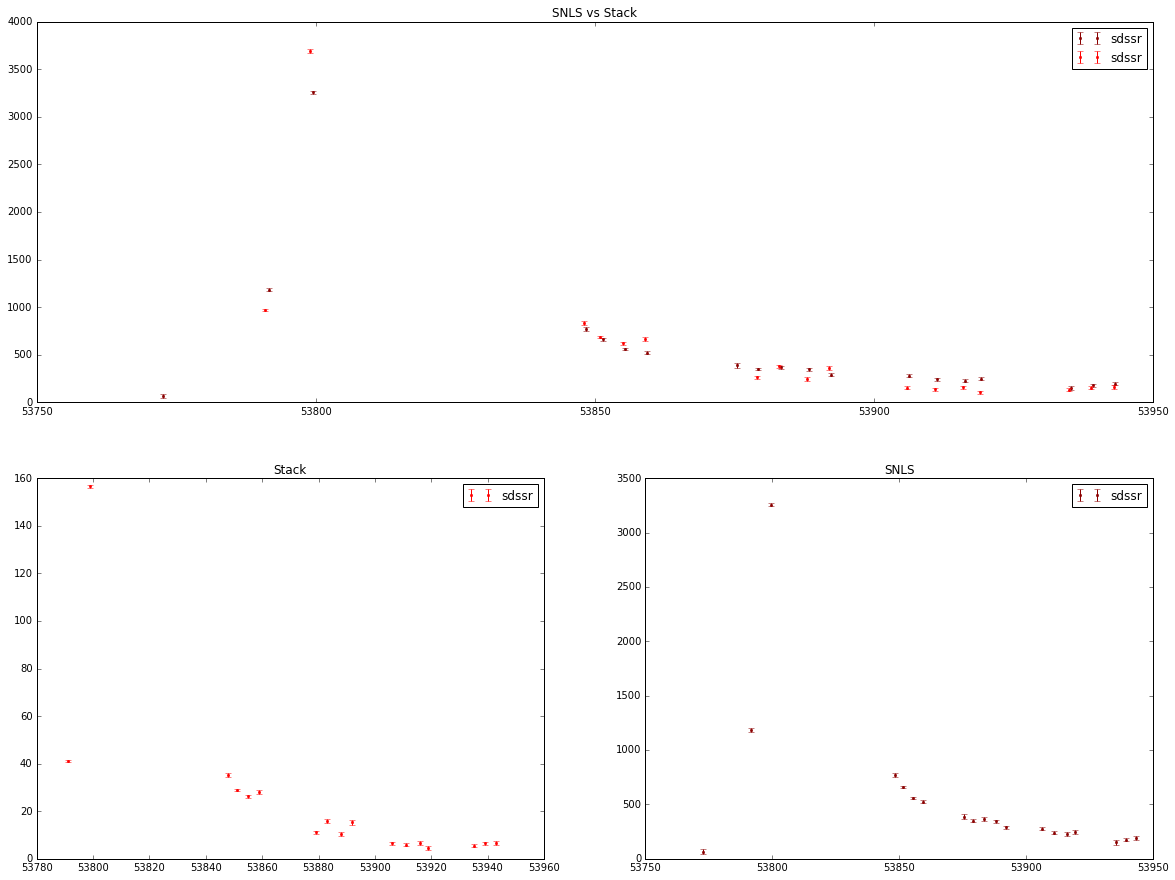

215.571826791 52.9576233385
{'sdssi': nan, 'sdssr': 23.777904545913017, 'sdssz': nan, 'sdssg': nan}


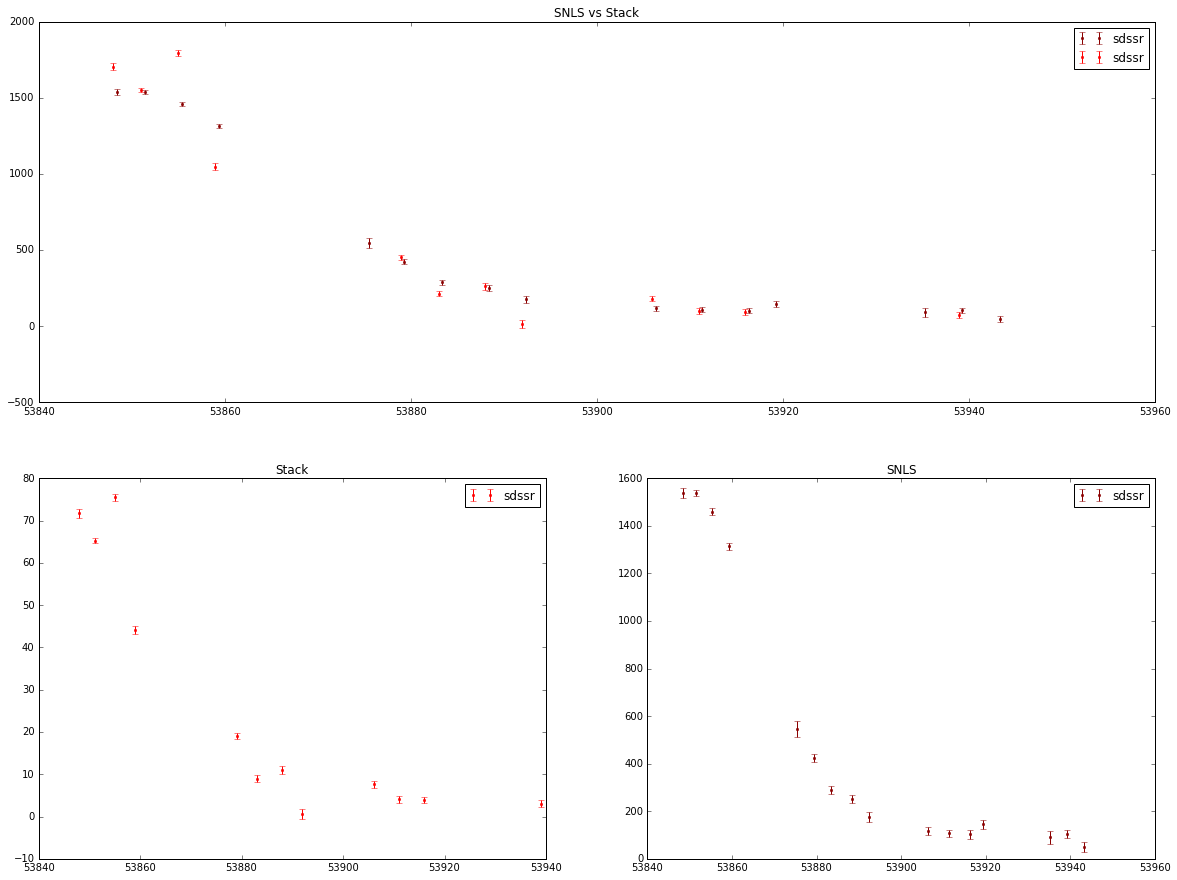

215.552332457 52.6408905403
{'sdssi': nan, 'sdssr': 21.217081669710264, 'sdssz': nan, 'sdssg': nan}


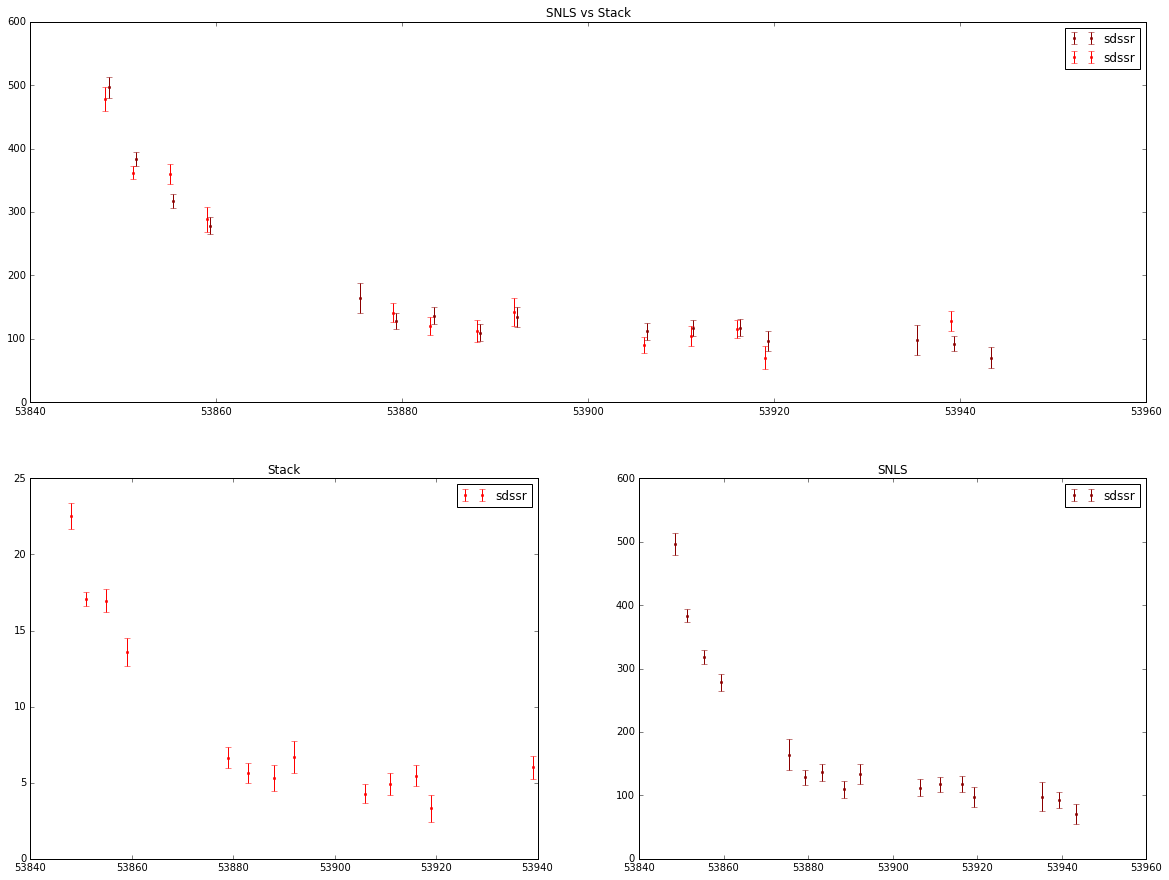

214.247555591 52.8824958162
{'sdssi': nan, 'sdssr': 21.64072651733586, 'sdssz': nan, 'sdssg': nan}


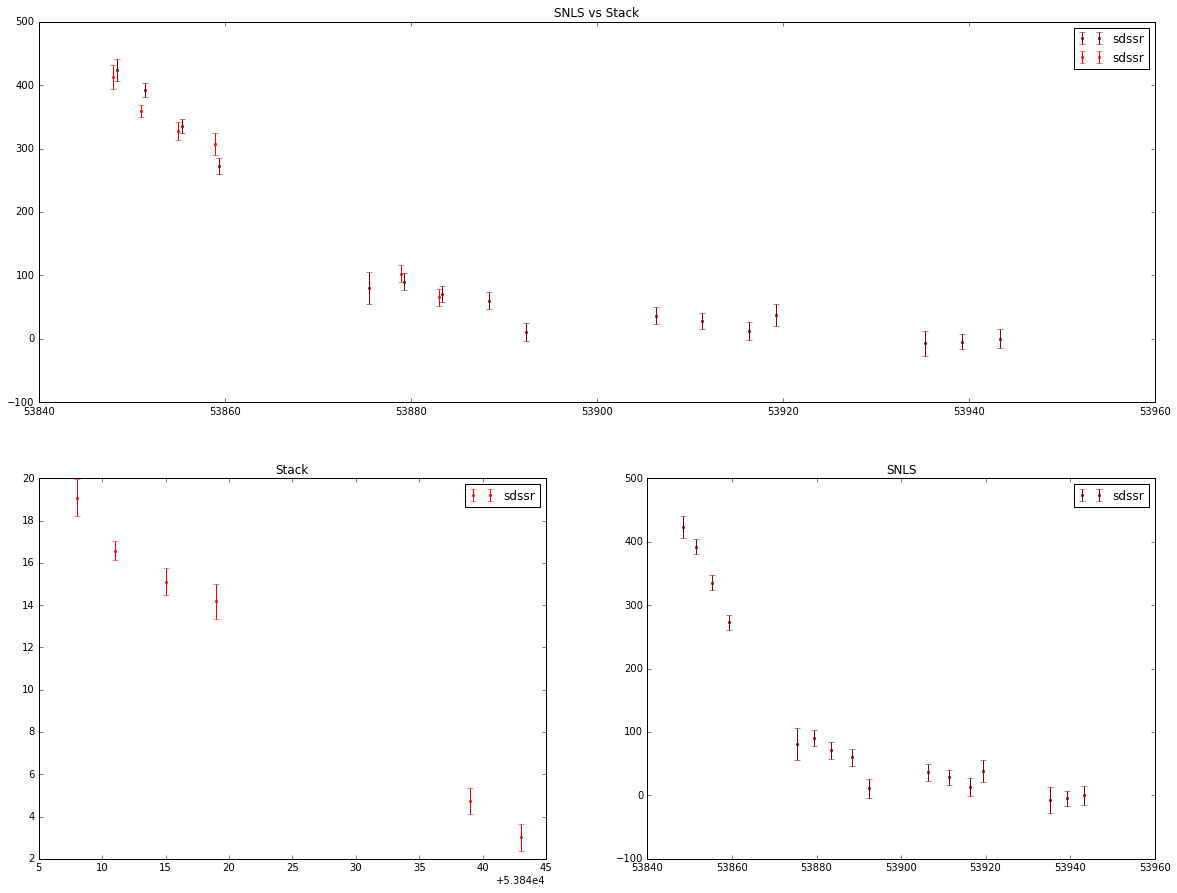

214.340170412 52.4528488343
{'sdssi': nan, 'sdssr': 21.463689255931651, 'sdssz': nan, 'sdssg': nan}


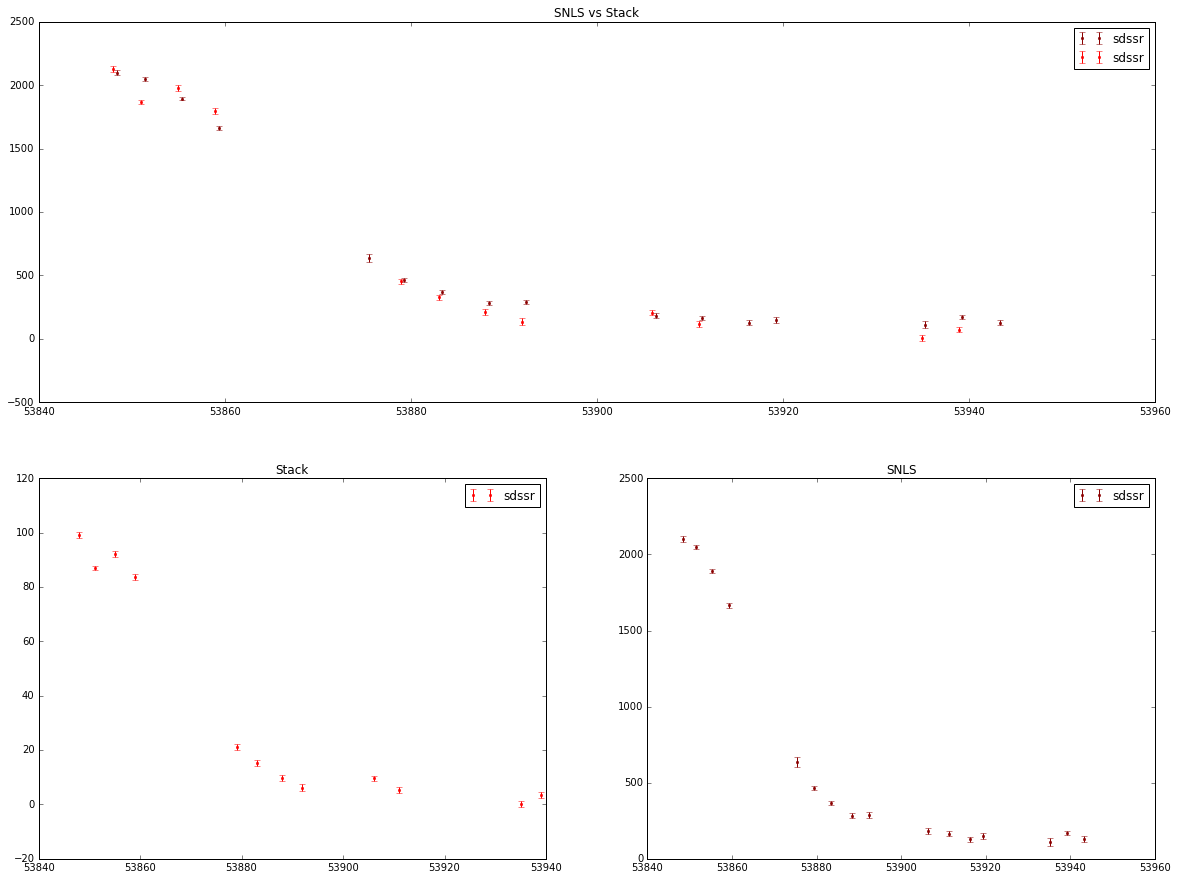

214.340157518 52.4528476835
{'sdssi': nan, 'sdssr': 21.860079519124874, 'sdssz': nan, 'sdssg': nan}


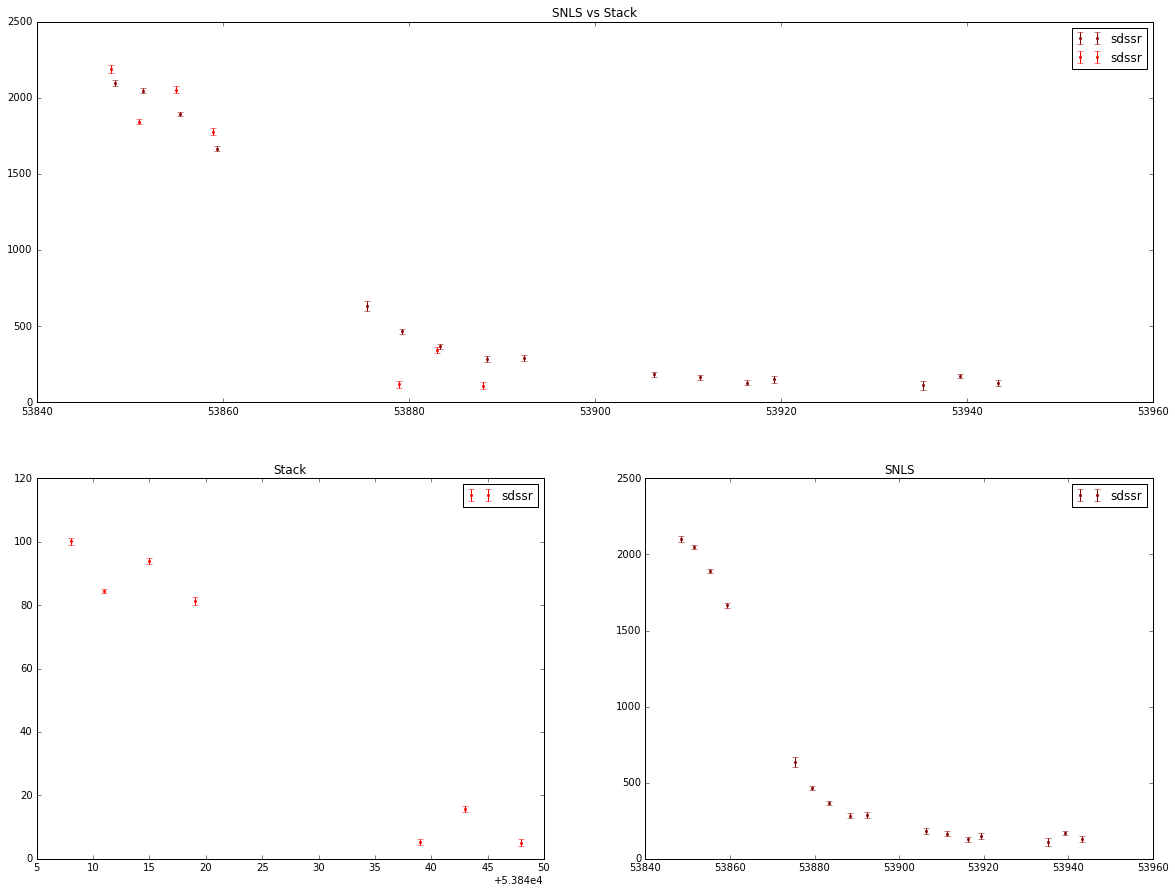

214.699341849 52.7565662266
{'sdssi': nan, 'sdssr': 21.438571098782042, 'sdssz': nan, 'sdssg': nan}


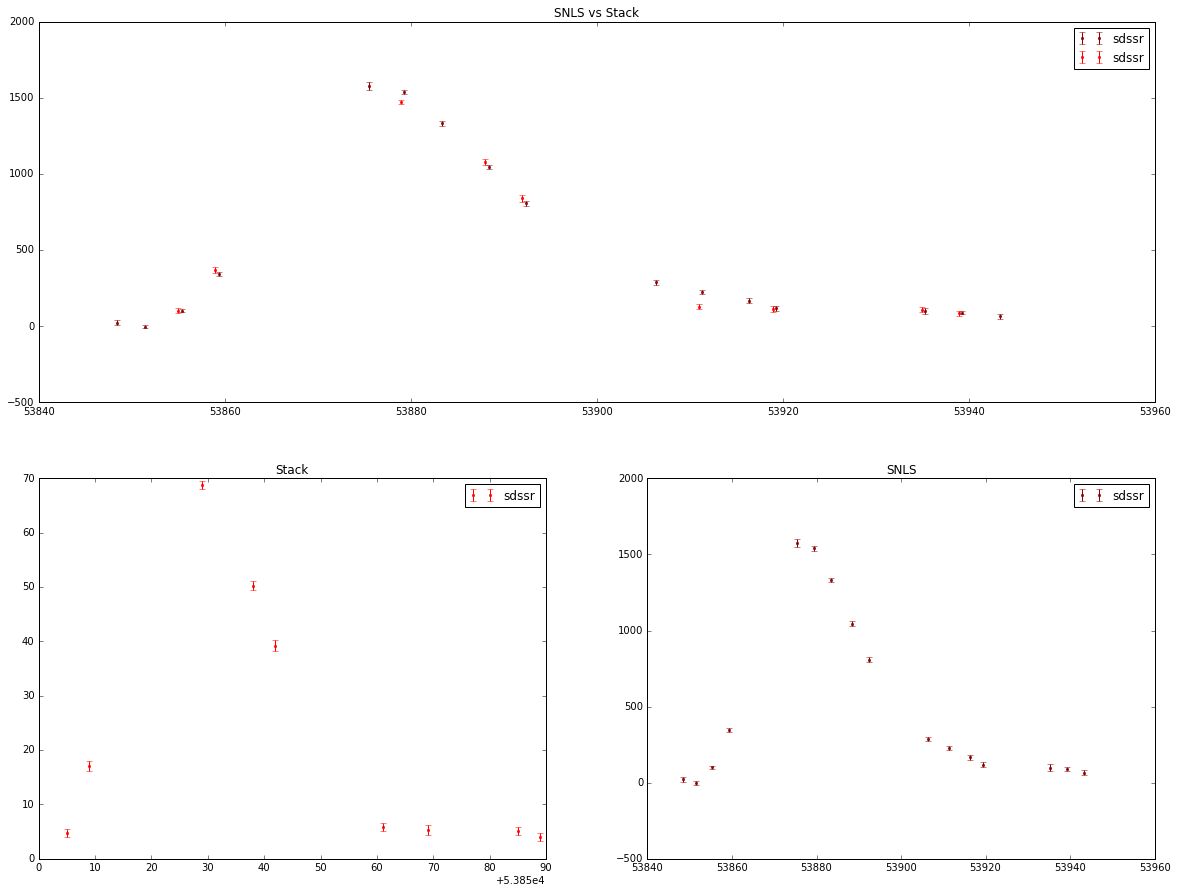

214.254418134 52.2324398885
{'sdssi': nan, 'sdssr': 20.423113033272383, 'sdssz': nan, 'sdssg': nan}


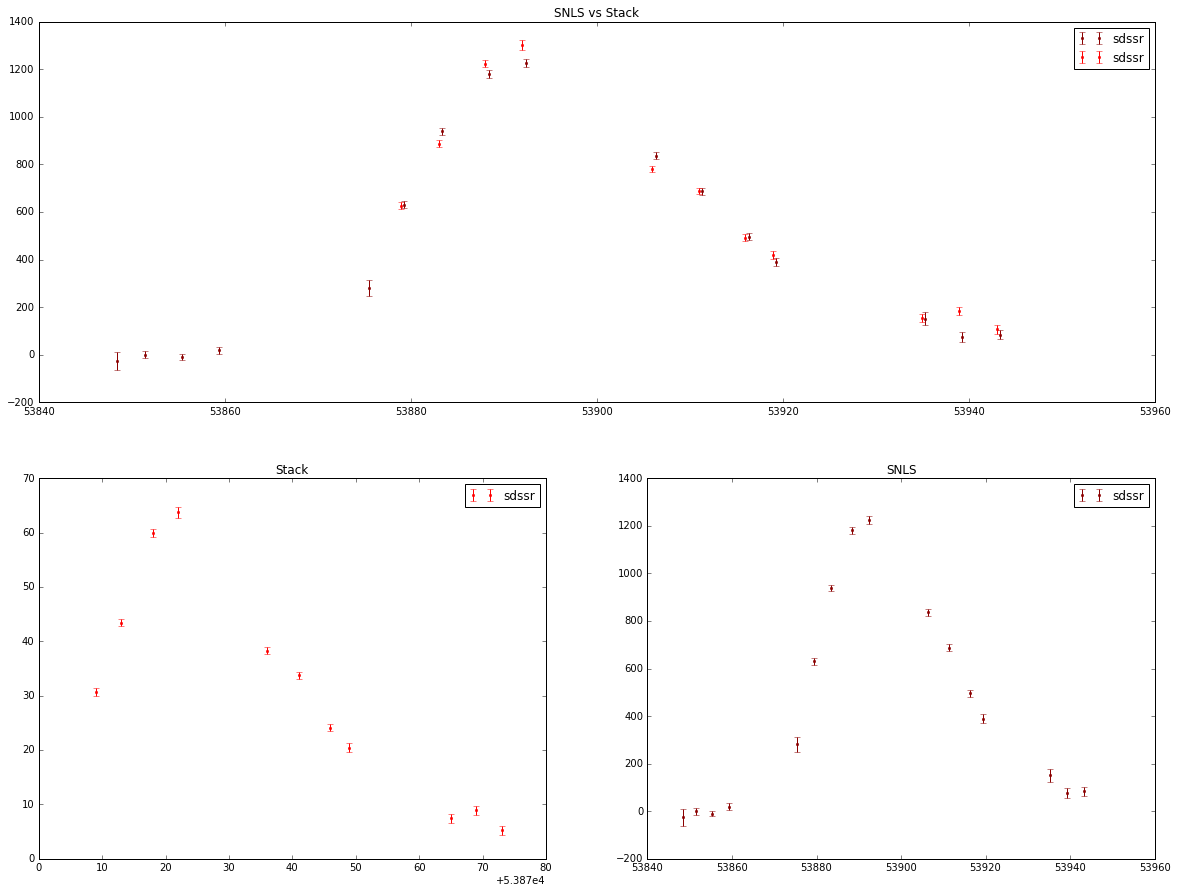

214.847686157 53.0229539782
{'sdssi': nan, 'sdssr': 21.34385214523498, 'sdssz': nan, 'sdssg': nan}


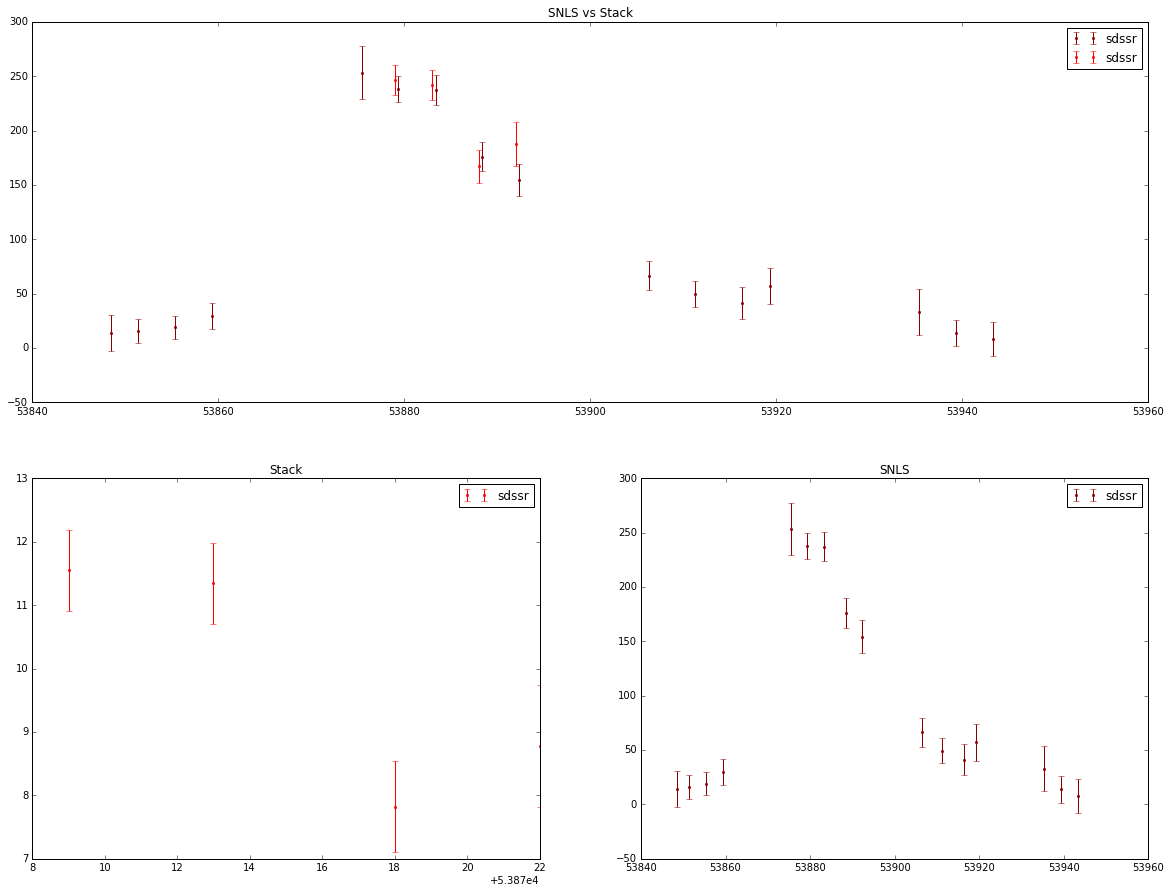

214.847700027 53.0229426323
{'sdssi': nan, 'sdssr': 20.356651768421472, 'sdssz': nan, 'sdssg': nan}


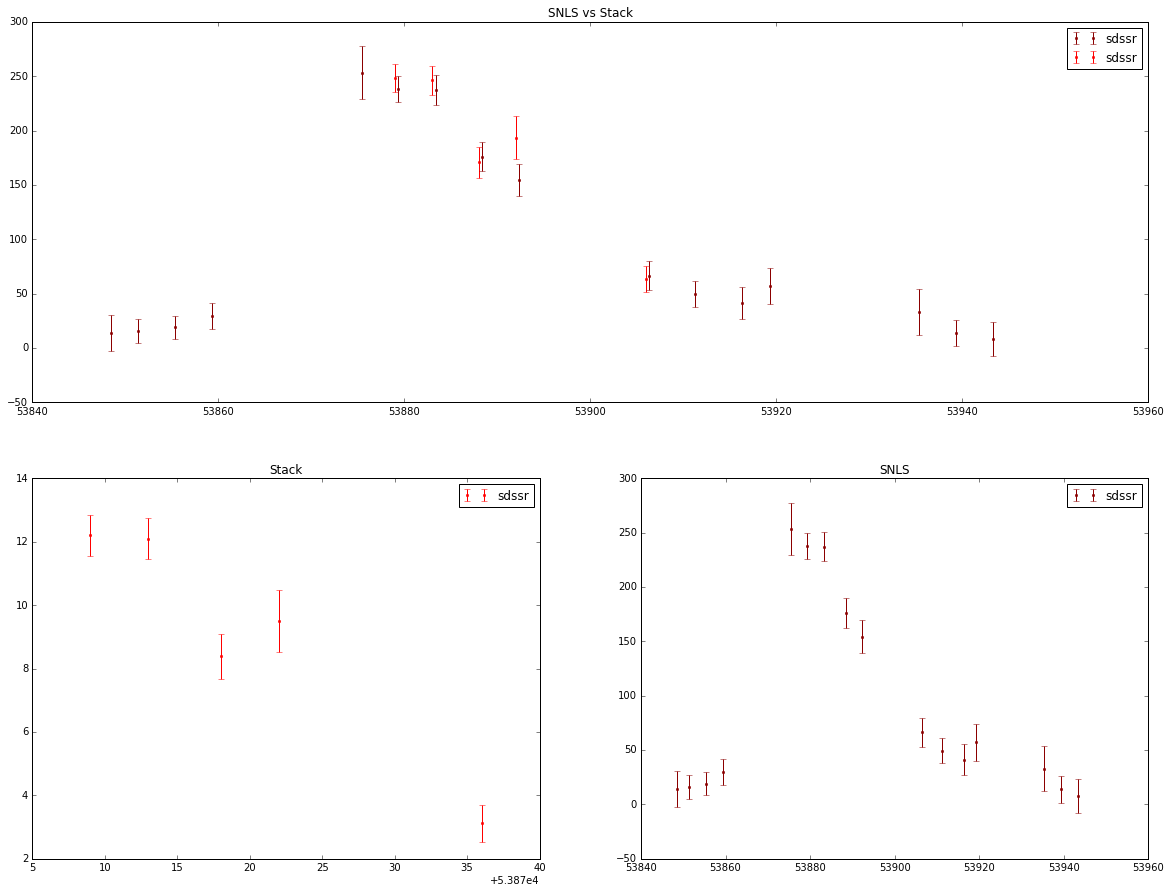

215.519748 52.3384824423
{'sdssi': nan, 'sdssr': 20.69141114891486, 'sdssz': nan, 'sdssg': nan}


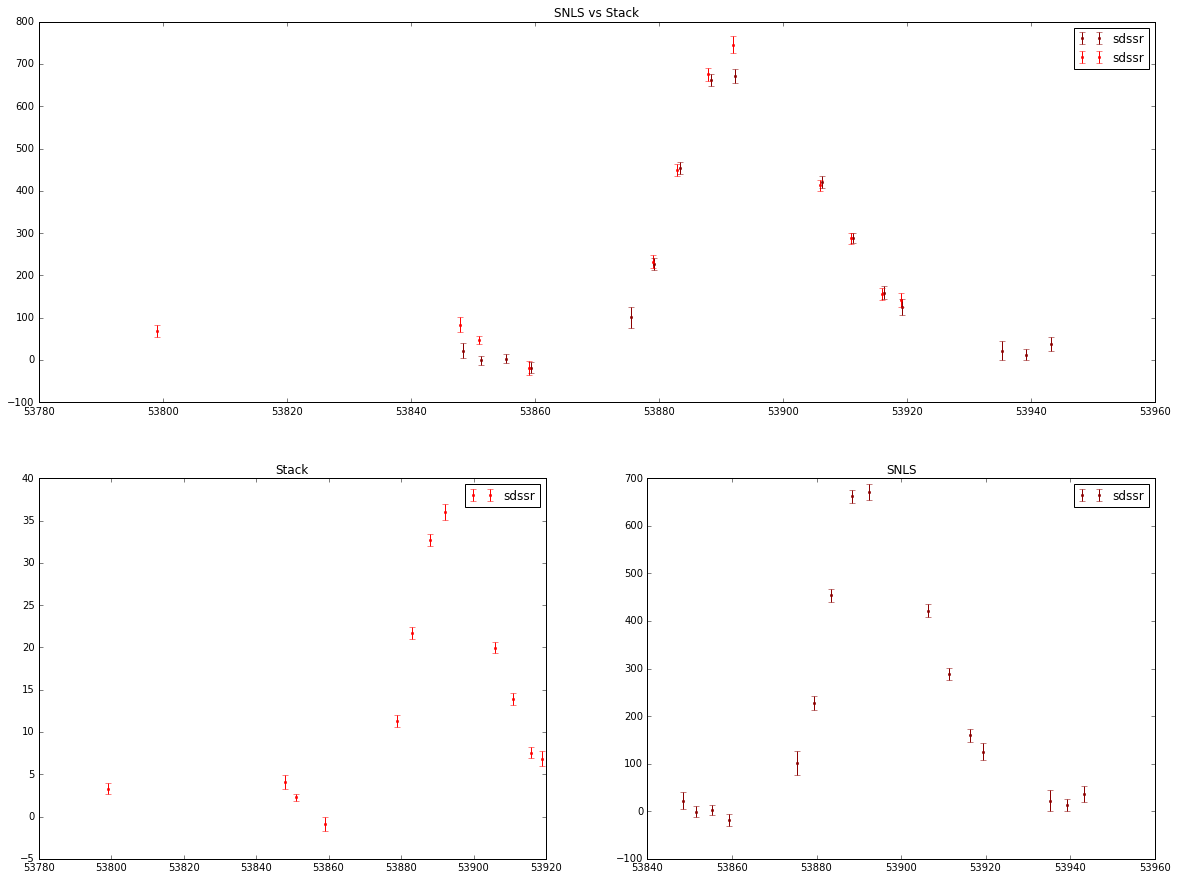

215.077579603 52.8970924618
{'sdssi': nan, 'sdssr': 21.809124217330574, 'sdssz': nan, 'sdssg': nan}


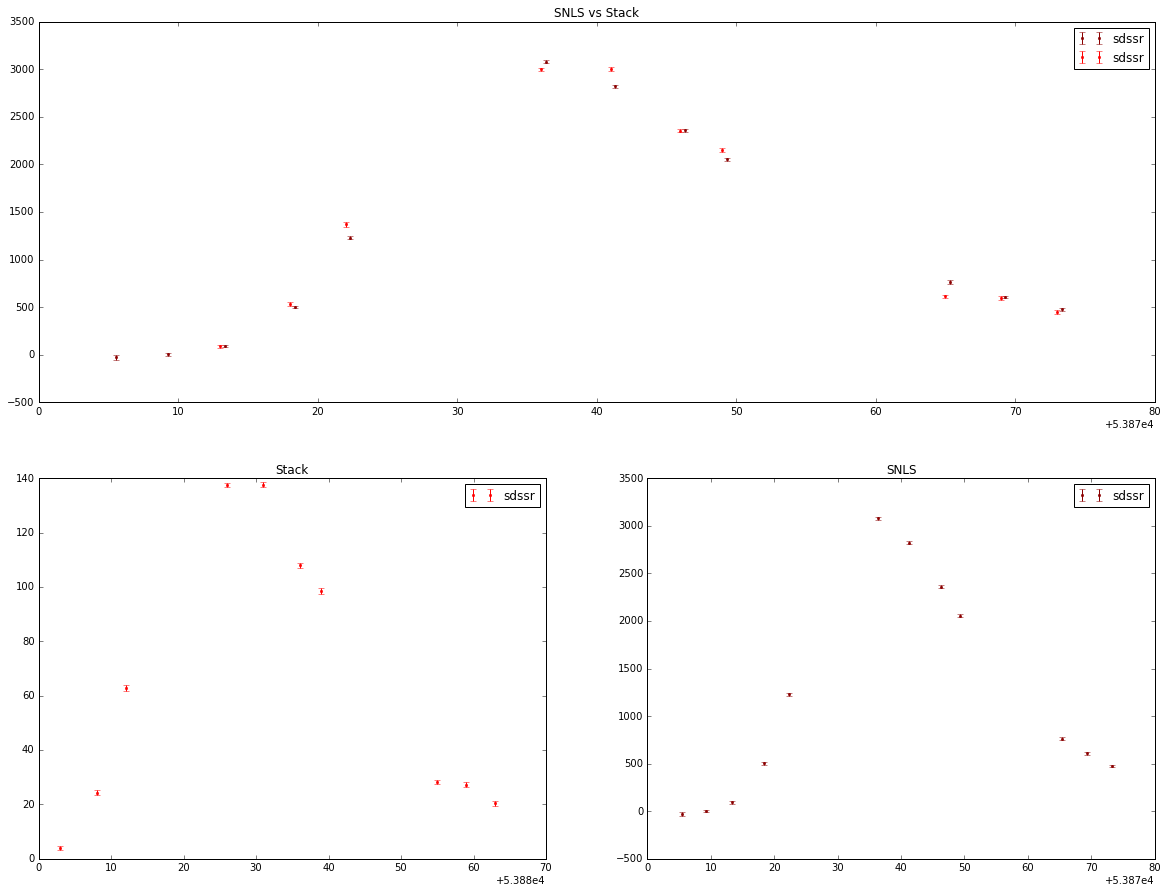

215.077533551 52.8971049329
{'sdssi': nan, 'sdssr': 21.52592412056298, 'sdssz': nan, 'sdssg': nan}


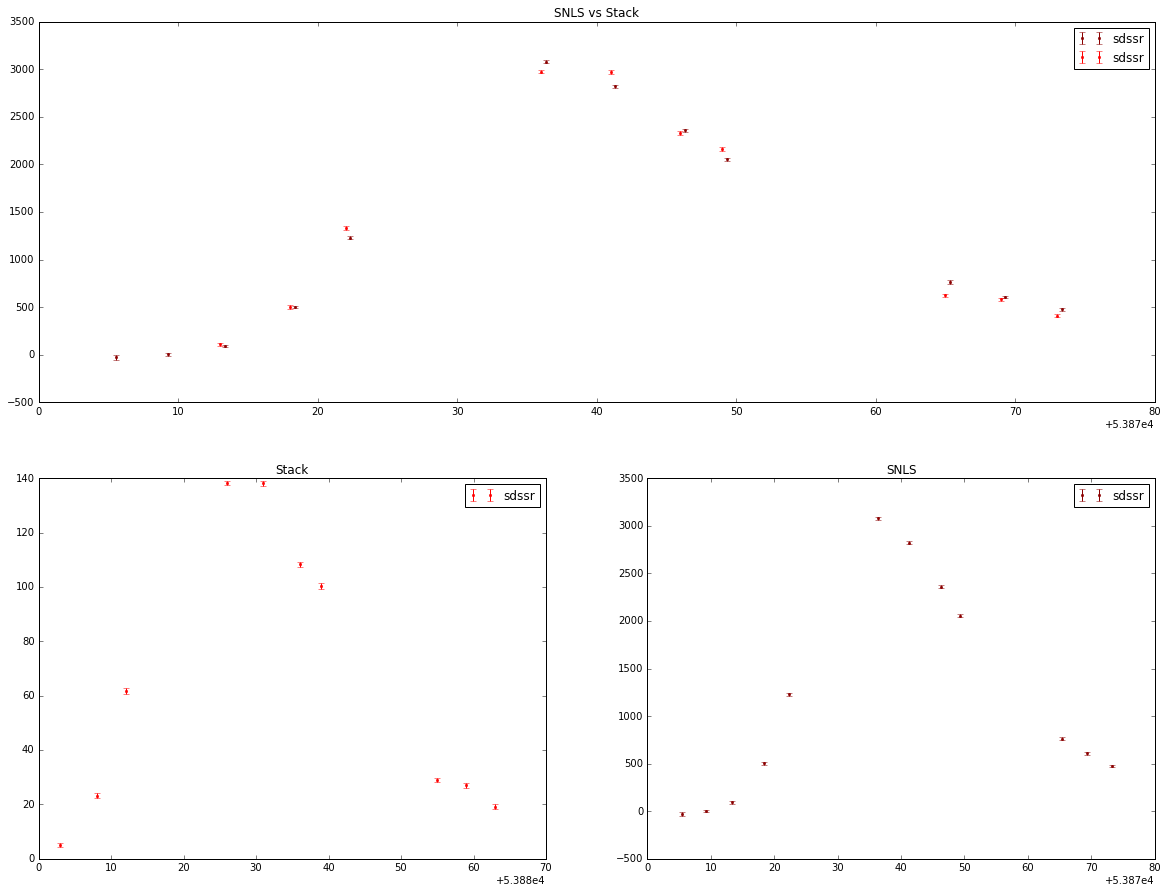

214.630795984 52.442967898
{'sdssi': nan, 'sdssr': 22.354542287567487, 'sdssz': nan, 'sdssg': nan}


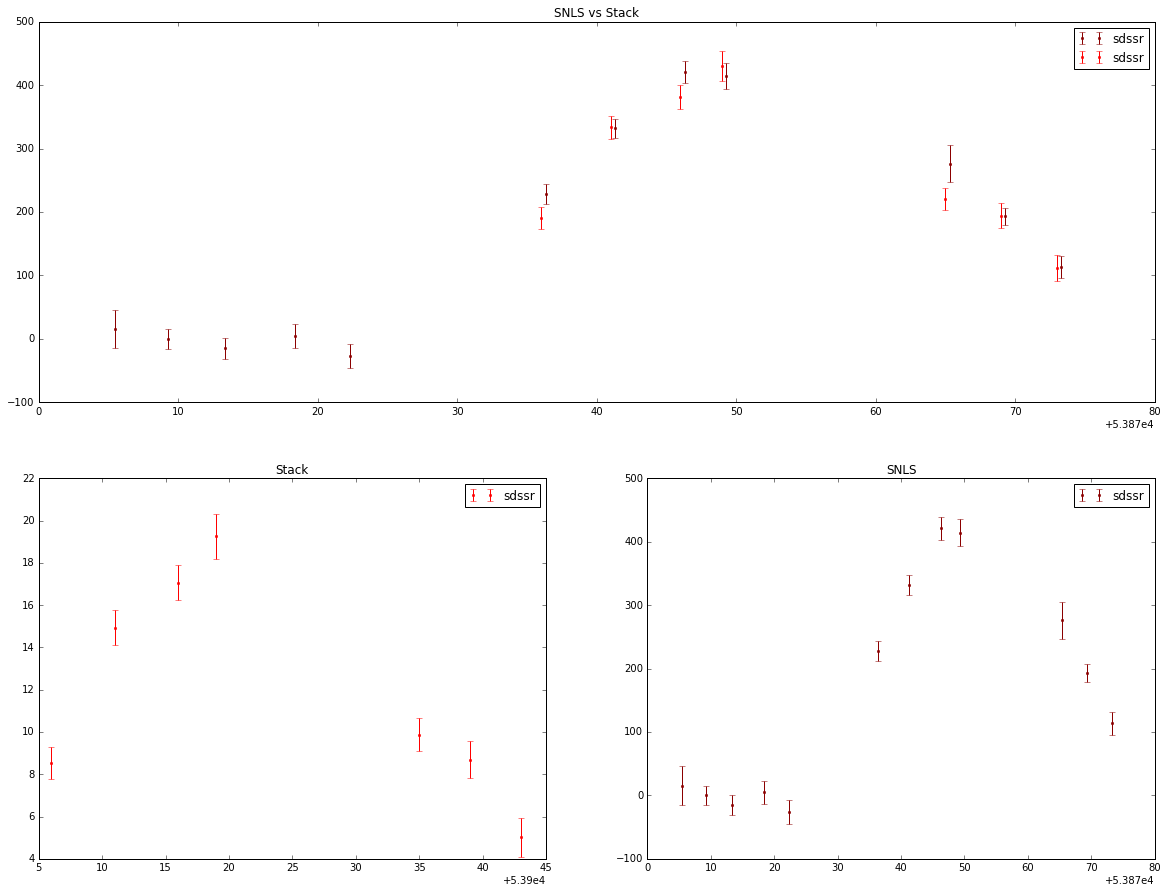

214.435883137 52.3613981649
{'sdssi': nan, 'sdssr': nan, 'sdssz': nan, 'sdssg': nan}


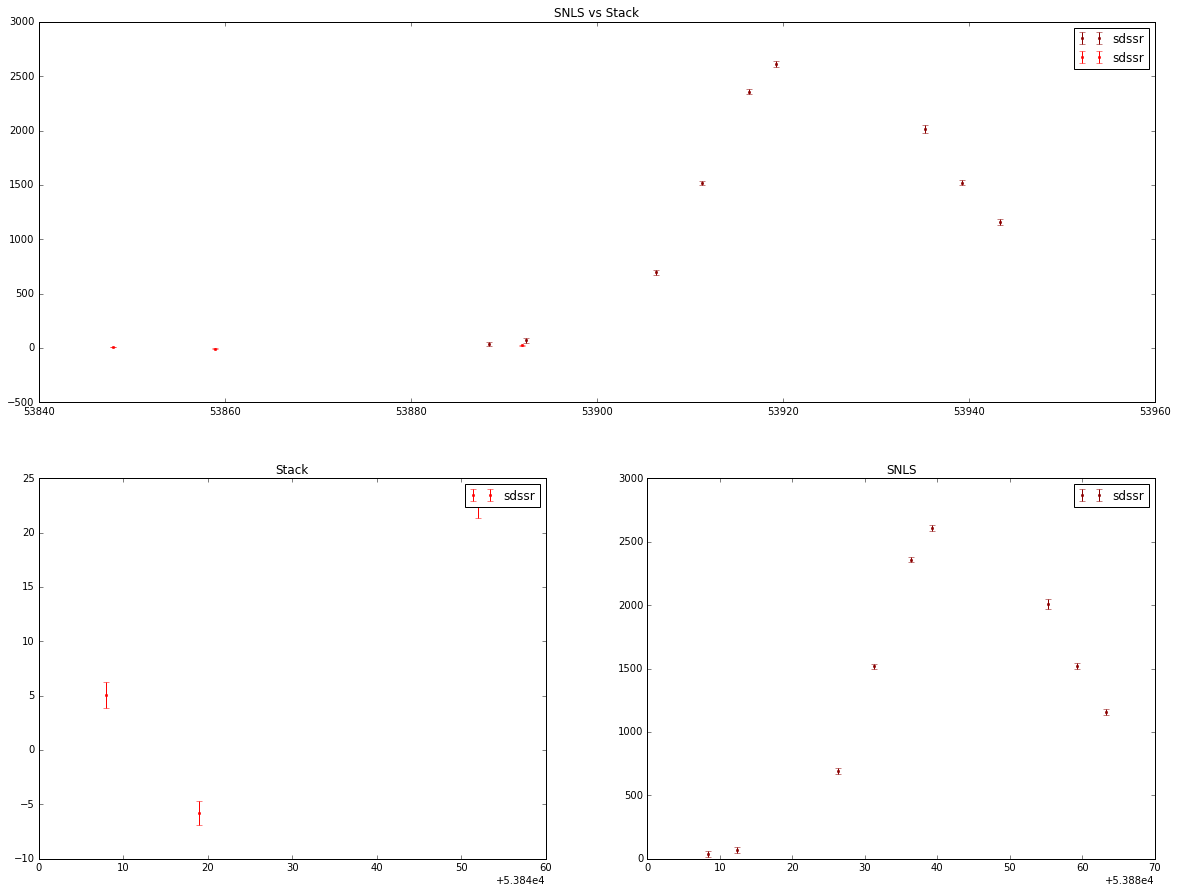

214.263561972 52.9362267351
{'sdssi': nan, 'sdssr': 21.541982558359486, 'sdssz': nan, 'sdssg': nan}


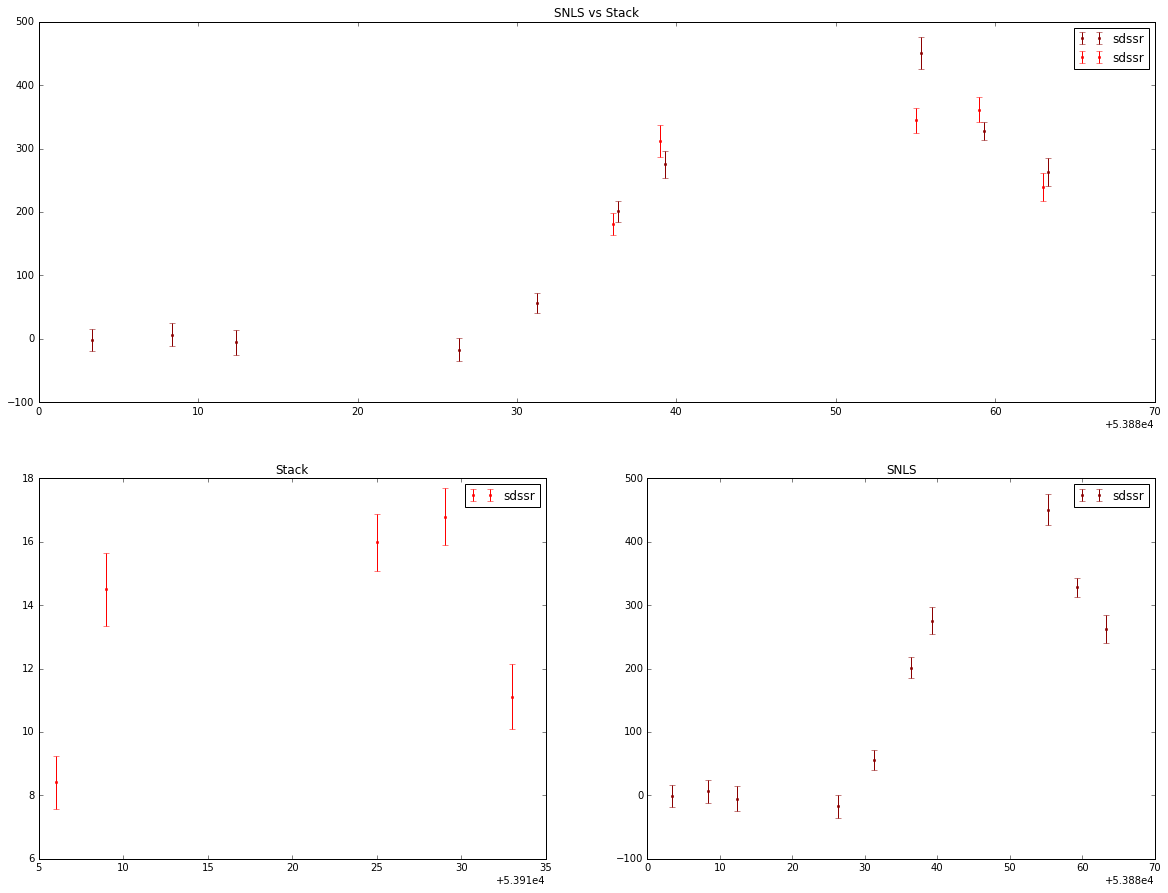

In [27]:
for match in matches_45:
    t = match[-1]
    

    plt.figure(figsize=(20,15))
    c = coord.SkyCoord(ra=float(np.mean(t['ra'])), dec=float(np.mean(t['dec'])), unit=(u.rad))
    print c.ra.deg, c.dec.deg
    
    plt.subplot2grid((2, 2), (0, 0), colspan=2)
    
    n_factors = {}
    n_factors["sdssi"]=normalize_light_curve( match[0],t, "sdssi")
    n_factors["sdssg"]=normalize_light_curve( match[0],t, "sdssg")
    n_factors["sdssr"]=normalize_light_curve( match[0],t, "sdssr")
    n_factors["sdssz"]=normalize_light_curve( match[0],t, "sdssz")
    
    print n_factors
    
    plt.title("SNLS vs Stack")
    show_multi_filter_light_curve(match[0], snls_colors)
    show_multi_filter_light_curve(t, stack_colors, n_factors)
    
    plt.subplot2grid((2, 2), (1, 0))
    plt.title("Stack")
    show_multi_filter_light_curve(t, stack_colors)
    
    plt.subplot2grid((2, 2), (1, 1))
    plt.title("SNLS")
    show_multi_filter_light_curve(match[0], snls_colors)
    plt.show()
    
   
    #t_by_filter = t.group_by("bandpass")

    #indices = t_by_filter.groups.indices
    #print indices

    #for i in range(0, len(indices)-1):

    #    data = t_by_filter[indices[i]:indices[i+1]]
        #print data
    #    plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5')
        
    #plt.show()
    #print "done"

In [19]:
def show_matches_2(matches):
    factors = []
    for match in matches:
        print len(match[-1])
        print np.rad2deg(match[0][0]['ra']), np.rad2deg(match[0][0]['dec'])
        lc_fluxes = match[0]["flux"]
        factor = max(match[-1]['flux']) / max(lc_fluxes)
        lc_fluxes = np.multiply(lc_fluxes, factor)
        lc_errors = np.multiply(match[0]["flux_error"], factor)
        
        factors.append(factor)
        plt.figure(figsize=(20,10))
        print match[-1]["flux"]
        plt.errorbar(match[-1]["mjd"], match[-1]["flux"],yerr=match[-1]["flux_error"], fmt='.', markersize='5')
        plt.errorbar(match[0]["mjd"], lc_fluxes, yerr=lc_errors, fmt='.', markersize='5')
        plt.show()

In [34]:
def FluxToMagnitud( flux,  zp):
    return zp-(2.5*np.log10(flux))

def FluxErrorToMagnitud(flux, error):
    return (2.5/np.log(10))*(error/flux)

In [54]:
writable_lcs[0]

mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass
int64,float64,str2,float64,object,float64,object,float64,str5
53801,4.0,ab,nan,3.73815252037,inf,0.920359071892,30.0,sdssi
53910,4.0,ab,nan,3.73815426396,inf,0.920363046934,30.0,sdssi
53919,4.0,ab,nan,3.73815464166,inf,0.920362931508,30.0,sdssi
53939,4.0,ab,nan,3.7381547755,inf,0.920363288688,30.0,sdssi
53766,4.0,ab,nan,3.73815967247,inf,0.92036664143,30.0,sdssi
53772,4.0,ab,nan,3.73815682707,inf,0.920362636196,30.0,sdssi
53855,4.0,ab,6.59291887283,3.73815972555,0.903293907642,0.920368219195,30.0,sdssi
53879,4.0,ab,nan,3.73815986103,inf,0.920366604737,30.0,sdssi
53892,4.0,ab,nan,3.73815303625,inf,0.920366628287,30.0,sdssi


In [31]:
writable_lcs = []
for lc in tot_lcs:
    t_by_filter = lc.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    if len(indices) > 2:
        writable_lcs.append(lc)

In [53]:
len(writable_lcs)

19346

In [60]:
from astropy.table import Column

from astropy.io import ascii

for i, lc in enumerate(writable_lcs):
    l = lc.copy()
    ms = []
    m_es = []
    for row in lc:
        row['ra'] = float(row['ra'])
        row['dec'] = float(row['dec'])
        row['zp'] = 30.0
        
        if np.isnan(row['flux']) == False and row['flux'] > 0: 
            f =  FluxToMagnitud(row['flux'], row['zp'])
            e = FluxErrorToMagnitud(row['flux'],row['flux_error'])
            ms.append(f)
            m_es.append(e)
        else:
            ms.append(np.nan)
            m_es.append(np.nan)
    c_ms = Column(ms, name='magnitude')
    c_m_es = Column(m_es, name='magnitude_error')
    l.add_column(c_ms)
    l.add_column(c_m_es)
        
    ascii.write(l, '/renoir_data_02/jpreyes/lsst_data/light_curves/multicolour_set/'+str(i)+'.dat')

In [12]:
date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":'r',"tract":0, "patch":'20,20', 'date':'2006-06-02'})
dayDiff =  butler.get("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":'20,20', 'date':'2006-06-02'})
ds9.mtv(dayDiff.getMaskedImage().getImage(), frame=1)

for source in date_catalog:
    #wcs = dayDiff.getWcs()
    #angle_ra = afwGeom.Angle(source["coord_ra"], afwGeom.rad)
    #angle_dec = afwGeom.Angle( source["coord_dec"] , afwGeom.rad)
    #coord = wcs.skyToPixel(angle_ra, angle_dec)
    ds9.dot("o", source.getX(), source.getY(), size = 25, ctype = ds9.RED, frame=1)

In [14]:
dayCoadd =  butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":'20,20', 'date':'2006-06-02'})
ds9.mtv(dayCoadd.getMaskedImage().getImage(), frame=3)

In [18]:
def visualize(patch, date, ra, dec, exp, frame=1):
    
    dataId= {"filter":filter,"tract":0, "patch":patch, 'date':date}
    dayDiff = butler.get(exp, dataId=dataId)
    catalog = butler.get("dayDiff_class_diaSrc", dataId=dataId)
    print len(catalog)
    ds9.mtv(dayDiff, frame=frame)
    ds9.setMaskTransparency(100, frame=frame)
    for source in catalog:

        ds9.dot("o", source.getX(), source.getY(), size = 25, ctype = ds9.RED, frame=frame)

    bbox = dayDiff.getBBox()
    wcs = dayDiff.getWcs()

    angle_ra = afwGeom.Angle(ra, afwGeom.degrees)
    angle_dec = afwGeom.Angle( dec , afwGeom.degrees)
    coord = wcs.skyToPixel(angle_ra, angle_dec)
    print coord
    ds9.dot("o", coord.getX(), coord.getY(), size = 20, ctype = ds9.BLUE, frame=frame)
    
def visualize2(patch, date, exp, frame=1):
    
    dataId= {"filter":filter,"tract":0, "patch":patch, 'date':date}
    dayDiff = butler.get(exp, dataId=dataId)
    catalog = butler.get("dayDiff_class_diaSrc", dataId=dataId)
    ds9.mtv(dayDiff, frame=frame)
    ds9.setMaskTransparency(100, frame=frame)
   

In [20]:
pa = '15,15'
ra = 215.18155833333333
dec = 52.191063888888884
filter='r'
exp1 = "deepCoadd"
exp2 = "dayCoadd"
exp3 = "dayDiff_differenceExp"

visualize(pa, '2006-02-06', ra, dec, exp3,  frame = 1)
#visualize2(pa, '2006-02-06', exp2, frame = 2)
#visualize2(pa, '2006-02-06', exp3, frame = 3)

118
(11080, 4944.5)


In [9]:
pa = '10,5'
ra = 215.18155833333333
dec = 52.191063888888884
filter='r'
exp = "dayCoadd"
#exp = "dayDiff_differenceExp"

visualize(pa, '2006-02-06', ra , dec , exp, frame = 4)

(11080, 4944.5)


In [13]:
cls = []
for lc in tot_lcs:
    cls.extend(lc['classification'].tolist())

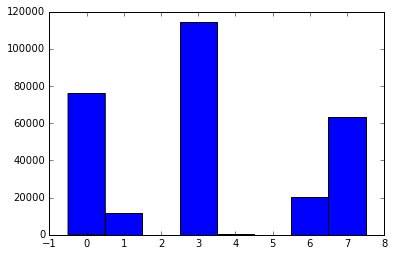

In [14]:
plt.hist(cls, bins=8,  align='left', range=(0,8))
plt.show()

In [32]:

for i, lc in enumerate(tot_lcs):
    l = lc.copy()
    ms = []
    m_es = []
    for row in lc:
        row['ra'] = float(row['ra'])
        row['dec'] = float(row['dec'])
        row['zp'] = 30.0

In [33]:
import astropy.coordinates as coord
import astropy.units as u

std_ra = []
std_dec = []

for i, lc in enumerate(tot_lcs):
    #print i
    c = coord.SkyCoord(float(np.std(lc["ra"])),float(np.std(lc["dec"])), unit=( u.rad))
    std_ra.append(c.ra.deg)
    std_dec.append(c.dec.deg)

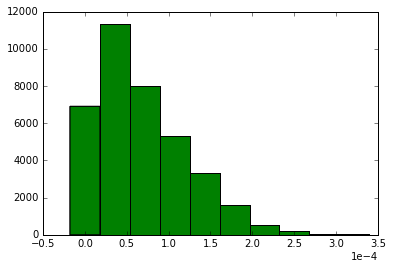

In [35]:
plt.hist(std_ra,  align='left')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.show()

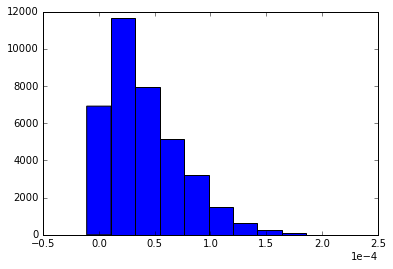

In [36]:
plt.hist(std_dec,  align='left')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.show()